<>:215: SyntaxWarning: invalid escape sequence '\m'
<>:215: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_5848/1718296613.py:215: SyntaxWarning: invalid escape sequence '\m'
  plt.colorbar(contour, ax=ax, label="Gravitational Anomaly ($\mu$Gal)")


Parsed GFC file successfully! Max Degree: 40
First few parsed spherical harmonic coefficients:
   L  M          C_lm          S_lm       sigma_C       sigma_S
0  0  0  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
1  1  0  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
2  1  1  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
3  2  0 -4.841692e-04  0.000000e+00  1.166597e-11  0.000000e+00
4  2  1 -3.350024e-10  1.498546e-09  1.059998e-11  1.024209e-11

Computing gravitational anomaly on a grid...


Computing anomaly:   0%|          | 0/38 [00:00<?, ?it/s]

/tmp/ipykernel_5848/1718296613.py:117: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  ylm = sph_harm(m, l, phi, theta)
Computing anomaly: 100%|██████████| 38/38 [00:36<00:00,  1.05it/s]
/tmp/ipykernel_5848/1718296613.py:130: RuntimeWarning: invalid value encountered in divide
  g_phi = -g_phi / (earth_radius * np.sin(theta))


Parsed GFC file successfully! Max Degree: 40


Computing anomaly: 100%|██████████| 38/38 [00:36<00:00,  1.05it/s]


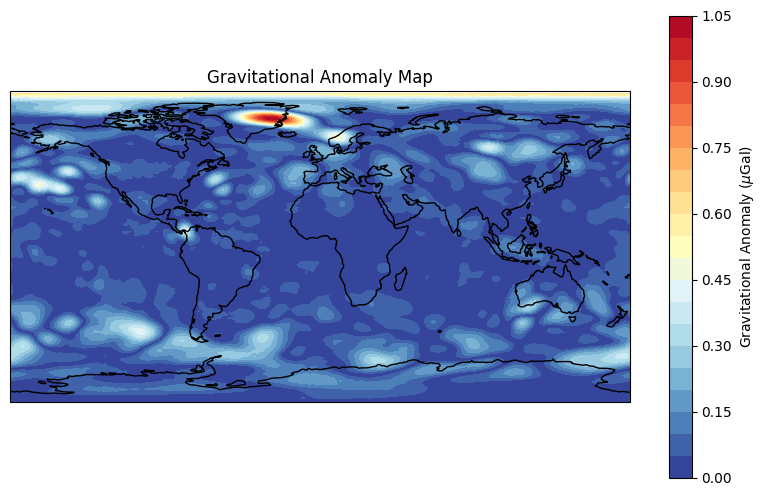

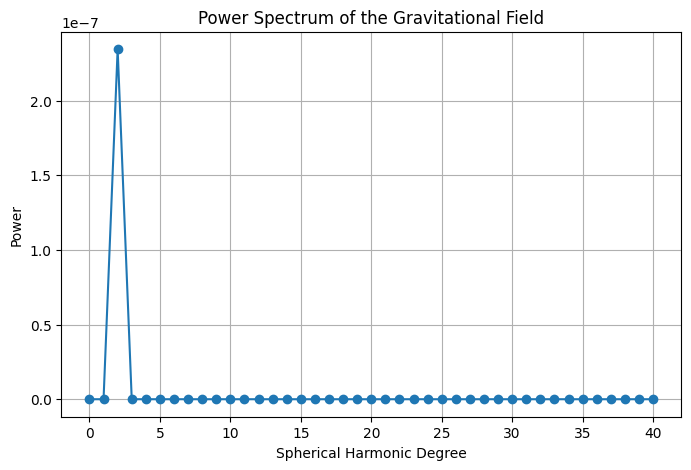

In [49]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
from scipy.special import sph_harm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


class GraceGFCProcessor:
    def __init__(self, gfc_file):
        self.gfc_file = gfc_file
        self.radius = None
        self.earth_gravity_constant = None
        self.max_degree = None
        self.tide_system = None
        self.harmonics = []  # List to hold [l, m, C_lm, S_lm, sigma_C, sigma_S]

    def parse_gfc_file(self):
        """Parses the GFC file and extracts spherical harmonic coefficients."""
        with open(self.gfc_file, "r") as file:
            lines = file.readlines()

        data_section = False

        for line in lines:
            line = line.strip()
            if "begin_of_head" in line:
                continue
            elif "end_of_head" in line:
                data_section = True
                continue

            if not data_section:
                # Extract metadata from the header
                if line.startswith("radius"):
                    self.radius = float(line.split()[1])
                elif line.startswith("earth_gravity_constant"):
                    self.earth_gravity_constant = float(line.split()[1])
                elif line.startswith("max_degree"):
                    self.max_degree = int(line.split()[1])
                elif line.startswith("tide_system"):
                    self.tide_system = line.split()[1]
            else:
                # Extract spherical harmonic coefficients
                if line.startswith("gfc"):
                    parts = re.split(r'\s+', line)
                    l = int(parts[1])      # Degree
                    m = int(parts[2])      # Order
                    c_lm = float(parts[3]) # C coefficient
                    s_lm = float(parts[4]) # S coefficient
                    sigma_c = float(parts[5])
                    sigma_s = float(parts[6])
                    self.harmonics.append([l, m, c_lm, s_lm, sigma_c, sigma_s])

        print(f"Parsed GFC file successfully! Max Degree: {self.max_degree}")

    def get_dataframe(self):
        """Returns the spherical harmonics as a Pandas DataFrame."""
        df = pd.DataFrame(
            self.harmonics,
            columns=["L", "M", "C_lm", "S_lm", "sigma_C", "sigma_S"],
        )
        return df

    def get_clm_slm_arrays(self):
        """
        Converts the list of harmonic coefficients into 2D arrays (clm and slm)
        with shape (max_degree+1, max_degree+1). For a given degree l and order m,
        the coefficient is stored at index [l, m].
        """
        clm = np.zeros((self.max_degree + 1, self.max_degree + 1))
        slm = np.zeros((self.max_degree + 1, self.max_degree + 1))
        for harmonic in self.harmonics:
            l, m, c_lm, s_lm, _, _ = harmonic
            if l <= self.max_degree and m <= self.max_degree:
                clm[l, m] = c_lm
                slm[l, m] = s_lm
        return clm, slm

    def compute_gravitational_anomaly(self, lon, lat, l_max, exclude_low_degrees, gm=None, earth_radius=None):
        """
        Computes the total gravitational anomaly using spherical harmonic synthesis.
        The function loops from degree 'exclude_low_degrees' to 'l_max', computing
        contributions using the real and imaginary parts of the spherical harmonic.

        :param lon: Longitude (in degrees); can be a scalar or NumPy array.
        :param lat: Latitude (in degrees); can be a scalar or NumPy array.
        :param l_max: Maximum spherical harmonic degree to use.
        :param exclude_low_degrees: Degrees lower than this are excluded from the summation.
        :param gm: Gravitational constant times Earth's mass. Defaults to self.earth_gravity_constant.
        :param earth_radius: Earth's radius. Defaults to self.radius.
        :return: Total gravitational anomaly (in microGals).
        """
        if gm is None:
            gm = self.earth_gravity_constant
        if earth_radius is None:
            earth_radius = self.radius

        # Convert lat/lon to colatitude (theta) and longitude (phi) in radians.
        # Theta = 90° - latitude.
        theta = np.radians(90 - np.array(lat))
        phi = np.radians(np.array(lon))

        g_theta = np.zeros_like(theta, dtype=np.float32)
        g_phi = np.zeros_like(theta, dtype=np.float32)
        g_r = np.zeros_like(theta, dtype=np.float32)

        # Get the coefficient arrays.
        clm, slm = self.get_clm_slm_arrays()

        # Loop over the spherical harmonic degrees and orders.
        for l in tqdm(range(exclude_low_degrees, l_max + 1), desc="Computing anomaly"):
            for m in range(l + 1):
                # Compute the spherical harmonic Y_lm at (phi, theta)
                ylm = sph_harm(m, l, phi, theta)
                ylm_real = ylm.real
                ylm_imag = ylm.imag

                # A simple approximation for the derivative with respect to theta:
                plm_derivative = np.cos(theta) * ylm_real

                g_theta += clm[l, m] * plm_derivative + slm[l, m] * np.sin(theta) * ylm_imag
                g_phi += m * (-clm[l, m] * ylm_imag + slm[l, m] * ylm_real)
                g_r += (l + 1) * (clm[l, m] * ylm_real + slm[l, m] * ylm_imag)

        # Convert the derivatives into acceleration components.
        g_theta = -g_theta / earth_radius
        g_phi = -g_phi / (earth_radius * np.sin(theta))
        g_r = -g_r * gm / earth_radius**2

        # Total horizontal and total gravitational acceleration
        g_h = np.sqrt(g_theta**2 + g_phi**2)
        g_total = np.sqrt(g_h**2 + g_r**2)

        # Convert to microGals (1 Gal = 1e8 microGal)
        g_total *= 1e8
        return g_total

    def compute_power_spectrum(self, Lmax):
        """
        Computes the power spectrum of the spherical harmonic coefficients up to degree Lmax.
        :param Lmax: Maximum degree for the power spectrum.
        :return: 1D NumPy array of power values.
        """
        clm, slm = self.get_clm_slm_arrays()
        power = np.zeros(Lmax + 1)
        for l in range(2, Lmax + 1):
            power[l] = np.sum(clm[l, :l + 1] ** 2 + slm[l, :l + 1] ** 2)
        return power


# =================== Example Usage ===================
if __name__ == "__main__":
    # Replace with the actual path to your GFC file.
    gfc_file = "ITSG_ITSG-Grace2014_daily_2006_ITSG-Grace2014_2006-11-14.gfc"
    processor = GraceGFCProcessor(gfc_file)
    processor.parse_gfc_file()
    
    # Optionally, display a few rows of the coefficients.
    df = processor.get_dataframe()
    print("First few parsed spherical harmonic coefficients:")
    print(df.head())

    # --- Compute Gravitational Anomaly ---
    # Set parameters for anomaly computation:
    l_max = 40                   # Maximum degree to include in the summation.
    exclude_low_degrees = 3     # Exclude the low-degree terms (e.g., for focusing on local anomalies).
    grid_size = 180              # Define the grid resolution for latitude and longitude.
    
    latitudes = np.linspace(-90, 90, grid_size)
    longitudes = np.linspace(0, 360, grid_size)
    lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)
    
    print("\nComputing gravitational anomaly on a grid...")
    anomaly1 = processor.compute_gravitational_anomaly(
        lon=lon_grid,
        lat=lat_grid,
        l_max=l_max,
        exclude_low_degrees=exclude_low_degrees,
        gm=processor.earth_gravity_constant,
        earth_radius=processor.radius,
    )

    gfc_file = "ITSG_ITSG-Grace2014_daily_2006_ITSG-Grace2014_2006-11-15.gfc"
    processor = GraceGFCProcessor(gfc_file)
    processor.parse_gfc_file()

    anomaly2 = processor.compute_gravitational_anomaly(
        lon=lon_grid,
        lat=lat_grid,
        l_max=l_max,
        exclude_low_degrees=exclude_low_degrees,
        gm=processor.earth_gravity_constant,
        earth_radius=processor.radius,
    )

    anomaly = anomaly2 - anomaly1



    # Plot the gravitational anomaly
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE)
    contour = ax.contourf(
        lon_grid,
        lat_grid,
        abs(anomaly),
        transform=ccrs.PlateCarree(),
        cmap="RdYlBu_r",
        levels=20,
    )
    plt.colorbar(contour, ax=ax, label="Gravitational Anomaly ($\mu$Gal)")
    plt.title("Gravitational Anomaly Map")
    plt.show()
    
    # --- Compute and Plot the Power Spectrum ---
    power = processor.compute_power_spectrum(Lmax=l_max)
    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(len(power)), power, marker='o')
    plt.xlabel("Spherical Harmonic Degree")
    plt.ylabel("Power")
    plt.title("Power Spectrum of the Gravitational Field")
    plt.grid(True)
    plt.show()


In [52]:
import pyshtools

coeffs = pyshtools.SHGravCoeffs.from_file("ITSG_ITSG-Grace2014_daily_2006_ITSG-Grace2014_2006-11-15.gfc",format='icgem')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spherical harmonic degree', ylabel='Power, m$^2$'>)

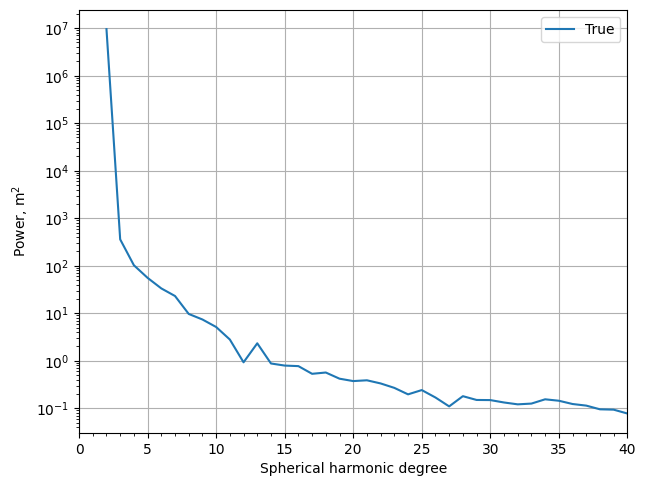

In [55]:
coeffs.plot_spectrum(unit='per_l',xscale='lin',yscale='log',legend=True)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Spherical harmonic degree', ylabel='Power, m$^2$'>)

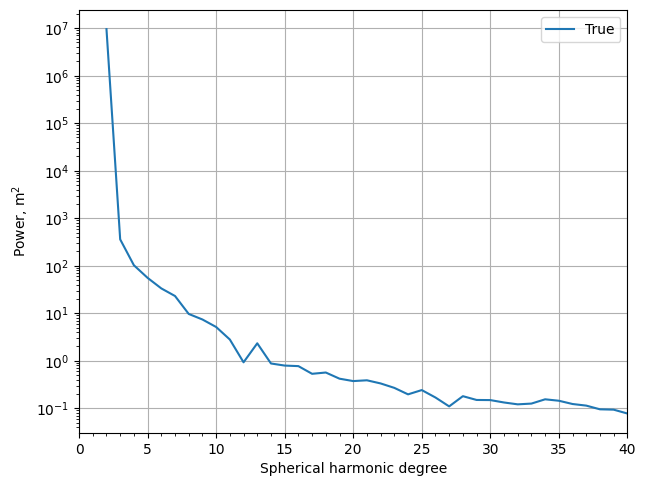

In [75]:
coeffs = pyshtools.SHGravCoeffs.from_file(
    "ITSG_ITSG-Grace2014_daily_2006_ITSG-Grace2014_2006-11-15.gfc", format="icgem"
)

coeffs.plot_spectrum(unit="per_l", xscale="lin", yscale="log", legend=True)

In [77]:
modified_coeffs = coeffs.coeffs.copy()


In [78]:
modified_coeffs

array([[[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-4.84169230e-04, -3.16725463e-10,  2.43934849e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [-2.42891196e-09,  5.09226001e-09,  7.50387002e-09, ...,
          2.80790556e-09,  0.00000000e+00,  0.00000000e+00],
        [ 1.29296498e-09, -4.43005616e-09,  3.06405402e-09, ...,
         -9.43950324e-10, -1.20297744e-10,  0.00000000e+00],
        [-6.21878232e-09,  3.80699560e-09, -1.12115362e-09, ...,
          3.74792100e-10,  6.46380973e-09, -1.77569476e-09]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e

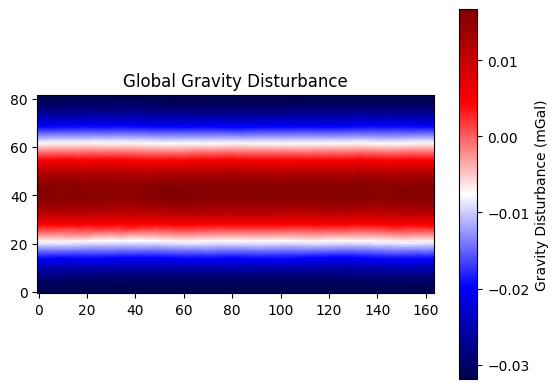

In [62]:
import matplotlib.pyplot as plt

# Plot the total gravity disturbance
plt.imshow(total, cmap='seismic', origin='lower')
plt.colorbar(label='Gravity Disturbance (mGal)')
plt.title('Global Gravity Disturbance')
plt.show()


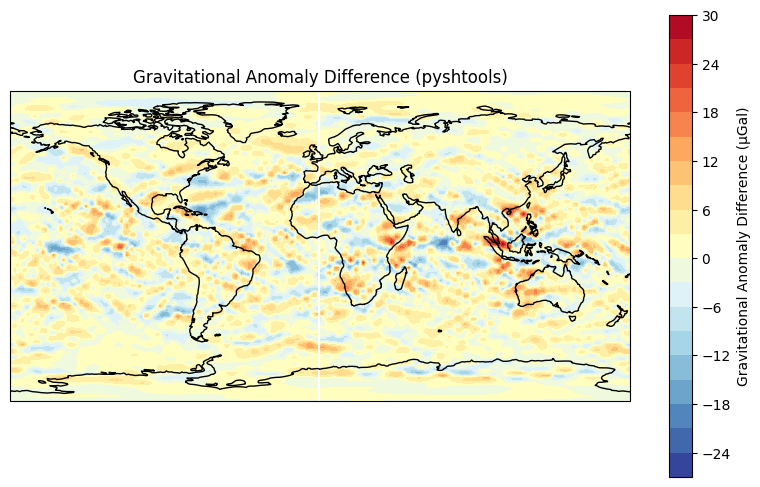

In [120]:
import pyshtools as pysh
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# https://icgem.gfz-potsdam.de/sp/01_GRACE/CSR/CSR%20Release%2006 (CSR RL06) provides the best results monthly

def load_sh_grav_coeffs(gfc_file):
    """Load spherical harmonic coefficients using pyshtools"""
    coeffs = pysh.SHGravCoeffs.from_file(gfc_file, format='icgem')
    return coeffs

def compute_gravity_anomaly_pyshtools(coeffs, grid_size=180):
    """Compute gravity anomalies using pyshtools' MakeGravGridDH"""
    # Get planetary constants
    gm = 3.9860044150e+14 
    r0 = 6.3781363000e+06

    # Compute gravity components (radial, colatitudinal, longitudinal, total, potential)
    rad, theta, phi, total, pot = pysh.gravmag.MakeGravGridDH(
        coeffs.coeffs, gm, r0, lmax=coeffs.lmax
    )

    return total

def compute_gravity_anomaly_excluding_first5(coeffs, grid_size=180):
    """Compute gravity anomaly while excluding the first 5 degrees (l = 0 to 4)."""
    # Get planetary constants
    gm = 3.9860044150e+14 
    r0 = 6.3781363000e+06

    # Copy coefficients and zero out degrees 0-4
    modified_coeffs = coeffs.coeffs.copy()  # Create a copy to avoid modifying the original data
    modified_coeffs[:, :40, :] = 0  # Set all C_lm and S_lm values for l = 0 to 4 to zero

    # Compute gravity anomaly with modified coefficients
    rad, theta, phi, total, pot = pysh.gravmag.MakeGravGridDH(
        modified_coeffs, gm, r0, lmax=coeffs.lmax
    )

    return total

if __name__ == "__main__":
    gfc_file1 = "CSR_CSR-Release-06_60x60_unfiltered_GSM-2_2006274-2006304_GRAC_UTCSR_BA01_0600.gfc"
    gfc_file2 = "CSR_CSR-Release-06_60x60_unfiltered_GSM-2_2006305-2006334_GRAC_UTCSR_BA01_0600.gfc"

    coeffs1 = pysh.SHGravCoeffs.from_file(gfc_file1, format='icgem')
    coeffs2 = pysh.SHGravCoeffs.from_file(gfc_file2, format='icgem')

    anomaly1 = compute_gravity_anomaly_excluding_first5(coeffs1)
    anomaly2 = compute_gravity_anomaly_excluding_first5(coeffs2)

    # Compute difference
    anomaly_difference = anomaly2 - anomaly1

    # Convert to microGal (µGal)
    anomaly_difference *= 1e8

    # Plot results
    grid_size = anomaly_difference.shape[0]
    latitudes = np.linspace(-90, 90, grid_size)
    longitudes = np.linspace(0, 360, 2 * grid_size, endpoint=False)
    lon_grid, lat_grid = np.meshgrid(longitudes, latitudes)

    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
    ax.set_global()
    ax.add_feature(cfeature.COASTLINE)
    contour = ax.contourf(
        lon_grid, lat_grid, anomaly_difference,
        transform=ccrs.PlateCarree(), cmap="RdYlBu_r", levels=20,
    )
    plt.colorbar(contour, ax=ax, label="Gravitational Anomaly Difference (µGal)")
    plt.title("Gravitational Anomaly Difference (pyshtools)")
    plt.show()

